In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tokenization

In [ ]:
!pip install wordcloud

In [ ]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import tokenization #pip install tokenization로 다운
from wordcloud import STOPWORDS #pip install wordcloud 다운

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/4자연어처리_bert/train.csv', dtype={'id': np.int16, 'target': np.int8})
#dtype함수는 특정 컬럼의 데이터 타입을 지정 (id : 16비트, target : 8비트) 하는 이유는 메모리 사용량을 최소화
df_test = pd.read_csv('/content/drive/MyDrive/4자연어처리_bert/test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
#.memory_usage()는 열별 메모리 사용량 반환. .sum()을 추가해서 전체 메모리 사용량 계산 / 1024 ** 2로 나누어 MB단위로 변환 후 소수점 둘째 자리 까지

print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


1KB = 1,024Bytes<BR>
1MB = 1,024 * 1,024Bytes = 1.024^2Bytes<BR>
1GB = 1,024^3bytes<BR>

따라서 MB로 변환하려면 1,024^2로 나눠야 함<BR>
GMB로 변환하려면 1,024^3으로 나누면 됌

##Missing Values
0.8% Key word
33% Location

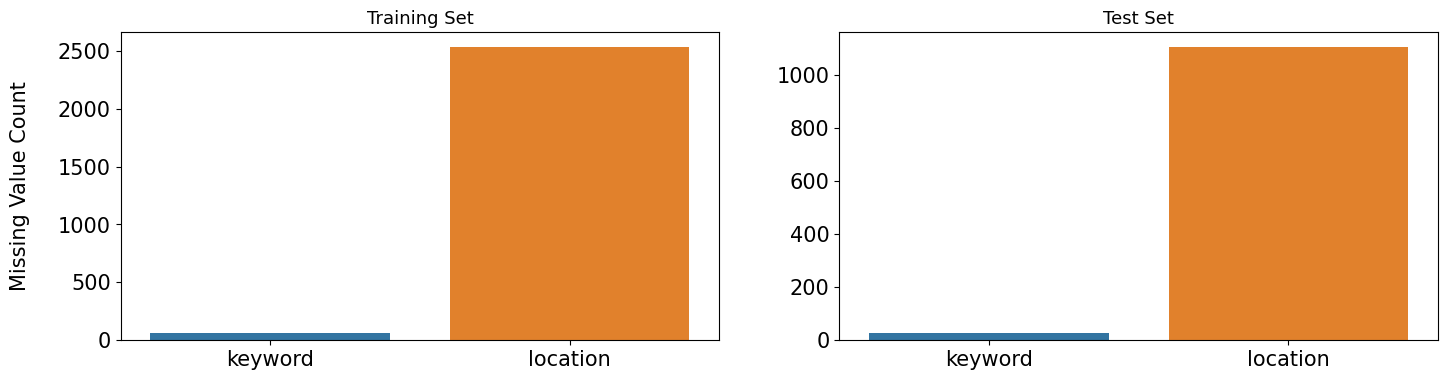

In [ ]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100) #dpi는 해상도 / 1인치당 100개의 점을 가진 그래프
#fig는 전체 그림을 참조, axes는 각각의 서브플롯을 참조하는 배

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
#x=df_train[missing_cols].isnull().sum().index 이 부분은 ["keword", "location"]으로 x축 추출 (단순히 x축 라벨만 추출하기 때문에 is_null, sum 함수는 필요 없긴 함)
# ->그래서 x=missing_cols로만 해도 됌!
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15) #tick_params는 눈금 라벨의 스타일을 설정. axis = x이면, x축의 눈금 라벨을 대상, axis =y면  y로 진행
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}') #null값인 곳에 no_keyword, no_location과 같이 no로 텍스트 채움

#location 데이터는 사용자가 직접 입력하는 데이터 -> 데이터가 너무 지저분하고 고유한 값이 너무 많음 (따라서 feature에서 제외)

#keyword는 사용가능할 수도

In [ ]:
# print(f"Number of unique values in keword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].unique()} (Test)") ""큰 따옴표로 시작하여, 내부에 ""큰 따옴표가 있어서 오류발생
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

#keyword & location 컬럼의 고유한 값 개수를 출력

#unique 함수는 series에서 중복을 제거한 고유한 값 반환 (키워드는 train과 test에서 동일하게 사용되는 것을 볼 수 있어서 유의미한 데이터로 판단) / 반면 location은 아님




Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


##training 값과 test값의 고유한 값이 같음 -> 같은 데이터를 이용하고 있다. (전체 train data -> 일부가 test데이터)

###그래프가 의미하는 것은 각 단어(keyword)가 있을 때 target값 0인지 1인지
즉, 각 keyword에 따라서 이 단어가 재난 단어인지, 재난 단어가 아닌지!

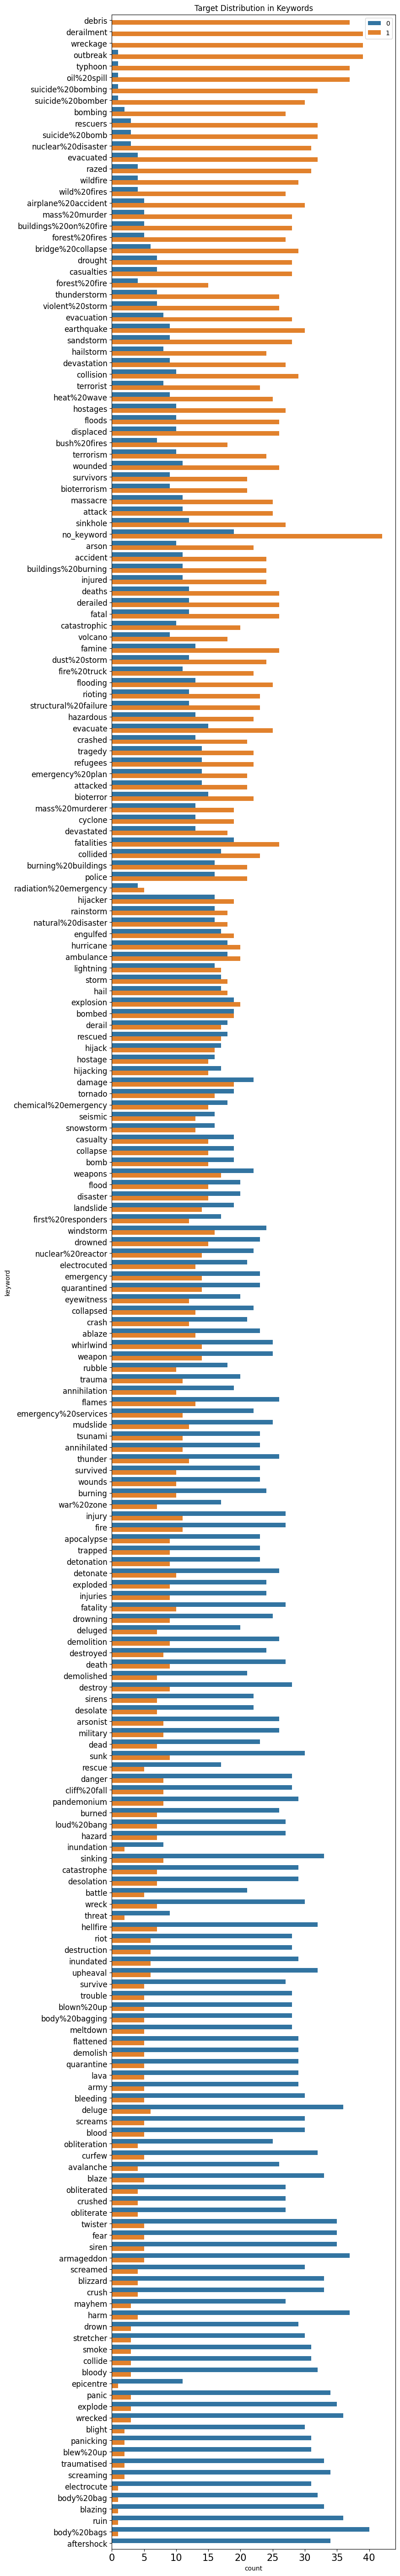

In [ ]:
df_train["target_mean"] = df_train.groupby("keyword")["target"].transform("mean") #train 데이터에서 keyword로 그룹화 한 후 target 컬럼의 평균값을 각 행에 넣음.
#keyword값에 0과 1이 있는데, 그 값을 평균으로 내어서 값을 넣어줌
#즉, train 데이터에 target_mean이 새로운 컬럼이 추가되고, 각 행의 keyword에 해당하는 target의 평균값이 저장

fig = plt.figure(figsize=(8,72), dpi = 100) #8 * 72 그림 객체

sns.countplot(y=df_train.sort_values(by="target_mean", ascending=False)["keyword"], #각 키워드에 따른 분포를 시각화
              hue=df_train.sort_values(by="target_mean", ascending=False)["target"])
#target_mean 컬럼 값을 기준으로 내림차순으로 데이터 정렬. 따라서 가장 큰 target_mean값을 가진 keyword부터 값이 나옴 / hue는 target 컬럼을 기준으로 색상 구분

plt.tick_params(axis="x", labelsize=15) #x축 눈금 라벨 크기
plt.tick_params(axis="y", labelsize=12) #y축 눈금 라벨 크기
plt.legend(loc=1) #범례 위치 loc=1은 우측 상단
plt.title("Target Distribution in Keywords")

plt.show()

df_train.drop(columns=["target_mean"], inplace=True) #target_mean 값 제거

#즉, keyword, target의 평균값을 계산하고, 이를 기준으로 keyword를 정렬하여 target의 분포를 막대 그래프로 시각화하는 작업을 수행.
#제목과 같이 keyword에 따른 target 분포


주황색 -> 1 재난 데이터 값 / 파란색 -> 0 재난 데이터가 아닌 값

word_count: number of words in text<br>
unique_word_count: number of unique words in text<br>
stop_word_count: number of stop words in text<br>
url_count: number of urls in text<br>
mean_word_length: average character count in words<br>
char_count: number of characters in text<br>
punctuation_count: number of punctuations in text<br>
hashtag_count: number of hashtags (#) in text<br>
mention_count: number of mentions (@) in text<br>

#각 열을 추가해서 "개수"만 나타냄!

In [ ]:
#word_count / "공백"기준으로 분리하여 단어의 리스트를 반환, len함수를 통해서 개수 카운트
df_train["word_count"] = df_train["text"].apply(lambda x: len(str(x).split()))
df_test["word_count"] = df_test["text"].apply(lambda x: len(str(x).split()))

#unique_word_count / 중복되는 단어 제거하고 고유한 단어의 개수만 계산 (튜플)
df_train["unique_word_count"] = df_train["text"].apply(lambda x: len(set(str(x).split())))
df_test["unique_word_count"] = df_test["text"].apply(lambda x: len(set(str(x).split())))

#stop_word_count / 불용어의 개수를 계산
df_train["stop_word_count"] = df_train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test["stop_word_count"] = df_test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

#url_count
df_train["url_count"] = df_train["text"].apply(lambda x: len([w for w in str(x).lower().split() if "http" in w or "https" in w]))
df_test["url_count"] = df_test["text"].apply(lambda x: len([w for w in str(x).lower().split() if "http" in w or "https" in w]))

#mean_word_length / 평균 단어 길이를 계산
df_train["mean_word_length"] = df_train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test["mean_word_length"] = df_test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#char_count / 텍스트 문자 개수
df_train["char_count"] = df_train["text"].apply(lambda x: len(str(x)))
df_test["char_count"] = df_test["text"].apply(lambda x: len(str(x)))

#punctuation_count / 텍스트에서의 구두점을 계산 (마침표, 느낌표와 같은 특수 문자)
df_train["punctuation_count"] = df_train["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test["punctuation_count"] = df_test["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#hashtag_count / 텍스트에서의 해시태그 개수
df_train["hashtag_count"] = df_train["text"].apply(lambda x: len([c for c in str(x) if c == "#"]))
df_test["hashtag_count"] = df_test["text"].apply(lambda x: len([c for c in str(x) if c == "#"]))

#mention_count / 텍스트에서의 멘션 개수
df_train["mention_count"] = df_train["text"].apply(lambda x: len([c for c in str(x) if c == "@"]))
df_test["mention_count"] = df_test["text"].apply(lambda x: len([c for c in str(x) if c == "@"]))

In [ ]:
df_train.head(10)

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,4.384615,69,1,1,0
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,38,1,0,0
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,133,3,0,0
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,0,4.500000,88,2,2,0
5,8,no_keyword,no_location,#RockyFire Update => California Hwy. 20 closed...,1,18,18,3,0,5.166667,110,7,3,0
6,10,no_keyword,no_location,#flood #disaster Heavy rain causes flash flood...,1,14,14,2,0,5.857143,95,3,2,0
7,13,no_keyword,no_location,I'm on top of the hill and I can see a fire in...,1,15,14,10,0,3.000000,59,4,0,0
8,14,no_keyword,no_location,There's an emergency evacuation happening now ...,1,12,11,5,0,5.666667,79,1,0,0
9,15,no_keyword,no_location,I'm afraid that the tornado is coming to our a...,1,10,10,6,0,4.300000,52,4,0,0


In [ ]:
df_test.head(10)

,id,keyword,location,text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,0,no_keyword,no_location,Just happened a terrible car crash,6,6,2,0,4.833333,34,0,0,0
1,2,no_keyword,no_location,"Heard about #earthquake is different cities, s...",9,9,2,0,6.222222,64,3,1,0
2,3,no_keyword,no_location,"there is a forest fire at spot pond, geese are...",19,19,10,0,4.105263,96,2,0,0
3,9,no_keyword,no_location,Apocalypse lighting. #Spokane #wildfires,4,4,0,0,9.250000,40,3,2,0
4,11,no_keyword,no_location,Typhoon Soudelor kills 28 in China and Taiwan,8,8,2,0,4.750000,45,0,0,0
5,12,no_keyword,no_location,We're shaking...It's an earthquake,4,4,2,0,7.750000,34,5,0,0
6,21,no_keyword,no_location,They'd probably still show more life than Arse...,12,12,4,0,5.083333,72,4,0,0
7,22,no_keyword,no_location,Hey! How are you?,4,4,2,0,3.500000,17,2,0,0
8,27,no_keyword,no_location,What a nice hat?,4,4,2,0,3.250000,16,1,0,0
9,29,no_keyword,no_location,Fuck off!,2,2,0,0,4.000000,9,1,0,0


##아래 각 컬럼들을 보여주는 그래프는 -> train과 test 데이터의 분포가 비슷하다 -> 비슷한 데이터라는 것을 의미함

데이터를 보니 train과 test의 데이터가 비슷함. 즉, train & test는 같은 샘플에서 나온 것<br>
메타데이터 전반적으로 좋지만, url / hastage_count / mention_count는 좋지 않음 -> 의미없다.<br>
word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count는 분포가 많이 다름<br>
분포가 다르다는 것은 (disaster tweets, non -disaster tweets)을 구별하는데 도움이 됌. 이러한 차이를 학습하여 분류 문제에서 그룹을 구별.

만약 두 그룹이 분포가 유사하면 해당 특징은 그룹을 구별하는데 어려움.



stratify: 훈련 / 텟트 데이터 나눌 때 사용 (클래스 분포가 불균형일 때)
-각 클래스의 비율이 원래 데이터셋과 동일하게 유지 (학습, 검증 세트가 분포를 유지하도록)

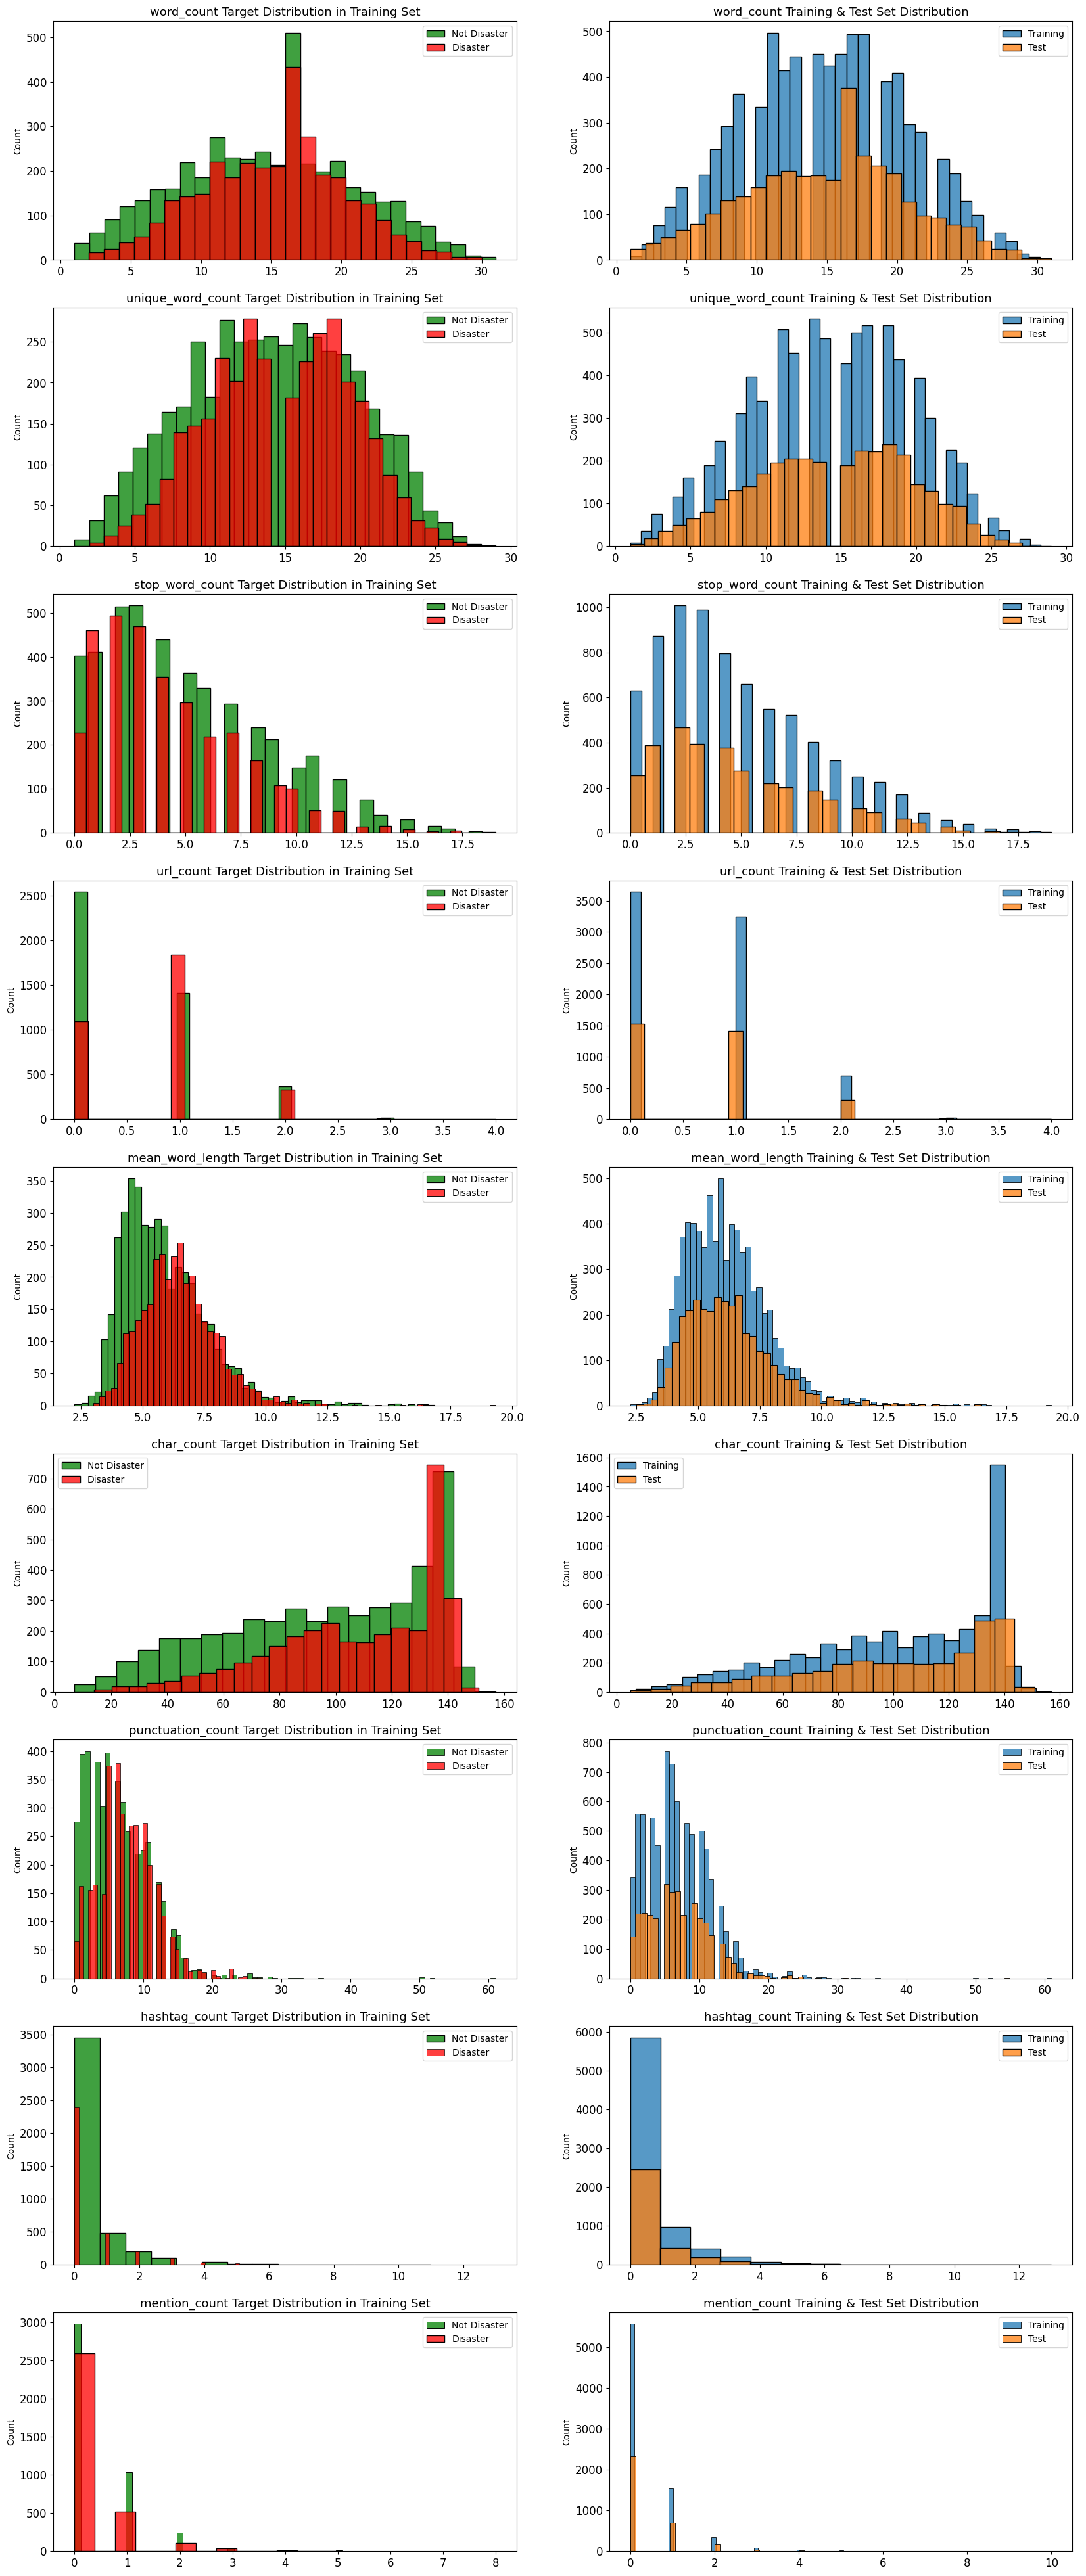

In [ ]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1 #disaster_tweets 값이 1일때 재난 상황 트윗

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES): #i는 0, feature는 "word_count"
#distplot -> histplot
    sns.histplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')# ~disaster_tweets 재난이 아닌 트윗
    sns.histplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')#disaster인 트윗
    #ax=axes[i][0]은 재난, 비재난 메타 특징 분포 표시
    #ax=axes[i][1]은 훈련 데이터와 테스트 데이터의 특징 분포 표시 ax에 관련된 두번째는 각 plot을 의미
    sns.histplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.histplot(df_test[feature], label='Test', ax=axes[i][1])

    for j in range(2): #각 서브플롯에 대해 x축 레이블을 지우고, x축 및 y축의 레이블 크기를 설정
    #여기서 j는 뒤 plot범례이니 (0,1)만 나오는 거 (0은 meta data) / (1은 훈련 테스트 데이터)
      axes[i][j].set_xlabel('')
      axes[i][j].tick_params(axis='x', labelsize=12)
      axes[i][j].tick_params(axis='y', labelsize=12)
      axes[i][j].legend()

    #여기는 들여쓰기 아님
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

##3. Target and N-grams

Target 0 (Not disaster) 57% / Target 1 (disaster) 43% #비슷한 분포

A와 B를 분류하는 단계에서, A가 80% B가 20%일 때는 불균형이 발생할 수 있음<BR>
특정 부분에서 추출을 했는데, A에서 모든 데이터가 추출 된다면 B 데이터는 없이 훈련을 함. <BR>
이럴 떄 Stratification(계층화)작업을 진행해주는 것<br>
하지만 여기서는 데이터가 균등적이게 있기 때문에 계층화 작업은 하지 않음

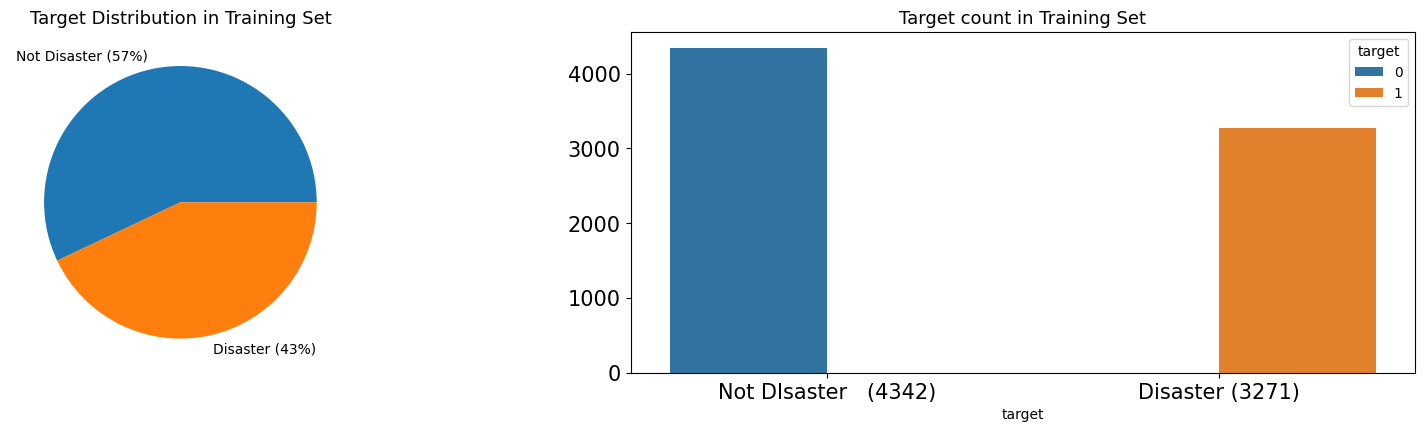

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(17,4), dpi=100)
plt.tight_layout() #plt.tight_layout()은 Matplotlib에서 플롯의 각 요소들
#(예: 축 레이블, 제목 등) 사이의 간격을 자동으로 조정하여 겹치는 부분을 방지하고, 그래프가 보기 좋게 보이도록 도와주는 함수

df_train.groupby("target").count()["id"].plot(kind="pie", ax=axes[0], labels=["Not Disaster (57%)", "Disaster (43%)"]) #pie 차트
#target을 기준으로 개수를 센 후 ["id"]의 개수만 남게 하라 -> 그래서 결국 target값에 따른 id의 개수만 값이 나옴 (id는 번호로 되어 있음)
#즉, target 값에 따른 not disaster, disaster만 남음
sns.countplot(x=df_train["target"], hue=df_train["target"], ax=axes[1]) #hue는 막대(target)사이즈의 크기를 기준으로 색 제공, countplot은 막대 그래프

axes[0].set_ylabel('') #축의 이름 제거
axes[1].set_ylabel('')
axes[1].set_xticklabels(["Not DIsaster   (4342)", "Disaster (3271)"])
axes[0].tick_params(axis="x", labelsize=15)
axes[0].tick_params(axis="y", labelsize=15)
axes[1].tick_params(axis="x", labelsize=15)
axes[1].tick_params(axis="y", labelsize=15)

axes[0].set_title("Target Distribution in Training Set", fontsize=13)
axes[1].set_title("Target count in Training Set", fontsize=13)

plt.show()

##n_gram: 텍스트 분석에서 흔히 사용되는 용어로, 연속된 "n"개의 항목(단어, 문자)를 의미. <br>
Unigram (1-gram): 각각의 단어나 문자를 개별 항목으로 보는 것입니다.
예: "I love programming" → ["I", "love", "programming"]<br>
Bigram (2-gram): 연속된 두 개의 단어나 문자의 조합입니다.
예: "I love programming" → ["I love", "love programming"]<br>
Trigram (3-gram): 연속된 세 개의 단어나 문자의 조합입니다.
예: "I love programming" → ["I love programming"]<br>
n_gram을 사용하는 이유는 문장의 문맥을 더 잘 포착, 연속된 단어의 조합은 문장의 의미를 더 정확하게 표현.
따라서 적절한 n의 크기를 선택

In [ ]:
def generate_ngrams(text, n_gram=1): #text에서 n-gram을 생성하는 함수
  token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS] #공백을 기준으로 하는 이유는 영어는 모든 단어가 띄어쓰기로 / if 문 2개 연결
  #text에서 소문자로 변환한 후 띄어쓰기를 기준으로 토큰화, 빈 문자열과 불용어를 제거
  #위에 if가 2개 있음 -> 빈 문자열, 불용어 제거 -> 공백도 아니고 불용어도 아닐 때 token 내보내라
  ngrams = zip(*[token[i:] for i in range(n_gram)]) #token화된 모든 리스트 나타냄 (n_gram 때문에 [i:])
  return [" ".join(ngram) for ngram in ngrams] #각각 나온 리스트들을 하나의 리스트로 합
'''
#zip 함수
동일한 위치에 있는 요소들끼리 묶어줌
a  = [1,2,3] / b = ["a", "b", "c"]를 a,b를 zip을 하면 [(1,"a"), (2."b"), (3,"c")]
'''
N = 100

#Unigrams
disaster_unigrams = defaultdict(int) #사전 생성
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]["text"]: #재난 데이터 먼저
  for word in generate_ngrams(tweet): #n_gram=1로 주워져서 n_gram은 설정하지 않음
    disaster_unigrams[word] += 1

for tweet in df_train[~DISASTER_TWEETS]["text"]: #재난 데이터가 아닌 것
  for word in generate_ngrams(tweet):
    nondisaster_unigrams[word] += 1

df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])
'''
disaster_unigrams.items()-딕셔너리의 항목들을 (키, 값)쌍의 리스트로 반환
key=lambda x : x[1]:
items()메서드를 통해 딕셔너리의 항목의 리스트로 변환 함. x[1]는 (키, 값) 중 "값 의미
따라서, key=lambda x : x[1]는 값을 기준으로  [0]은 키 [1]는 값
[::-1]리스트의 순서를 뒤집는 것 -> range함수에서 step만 -1로 뒤집은 것 (리스트의 순서 뒤집음 의미)

'''

#Big grams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]["text"]:
  for word in generate_ngrams(tweet, n_gram=2):
    disaster_bigrams[word] += 1

for tweet in df_train[~DISASTER_TWEETS]["text"]:
  for word in generate_ngrams(tweet, n_gram=2):
    nondisaster_bigrams[word] += 1

df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

#Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]["text"]:
  for word in generate_ngrams(tweet, n_gram=3):
    disaster_trigrams[word] += 1

for tweet in df_train[~DISASTER_TWEETS]["text"]:
  for word in generate_ngrams(tweet, n_gram=3):
    nondisaster_trigrams[word] += 1

df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

In [ ]:
df_disaster_unigrams.head(5)

,0,1
0,-,389
1,fire,150
2,via,117
3,...,105
4,&amp;,105


In [ ]:
df_disaster_bigrams.head(5)

,0,1
0,suicide bomber,59
1,northern california,40
2,oil spill,37
3,california wildfire,31
4,bomber detonated,30


In [ ]:
df_disaster_trigrams.head(5)

,0,1
0,suicide bomber detonated,30
1,bomber detonated bomb,28
2,pkk suicide bomber,28
3,homes razed northern,28
4,latest: homes razed,28


##unigram 데이터의 경우 대부분 구두점(특수 기호)들이 많음. 이 데이터들은 target 데이터에 영향을 주지 못 함 (따라서 전처리 과정 필요)
unigram -> dieaster 정보 주고 있음.
unigram -> non-dieaster은  동사가 많음.(비공식적인 활동 구조 / 개인들 사용에서)


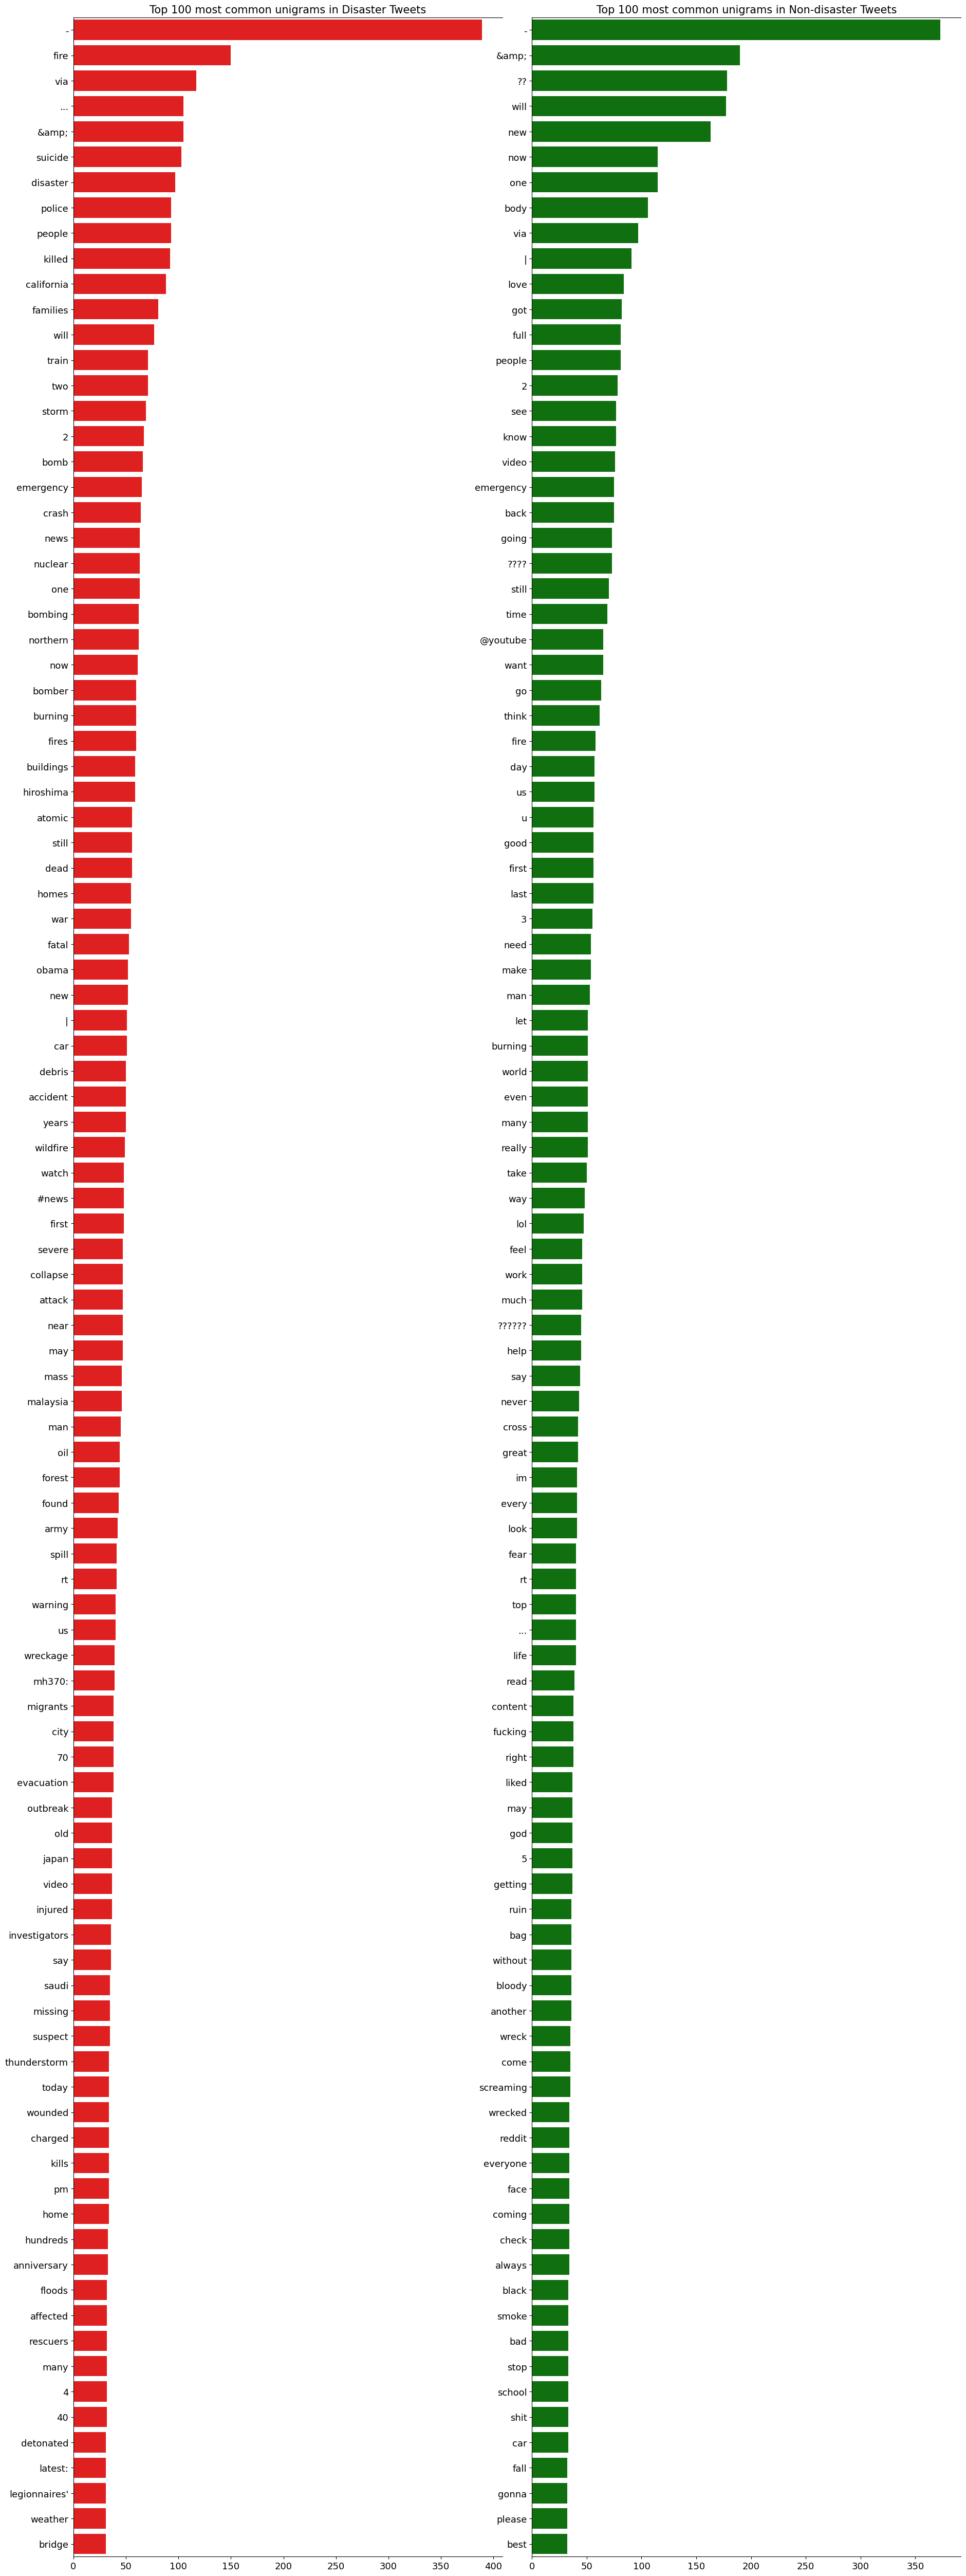

In [ ]:
#상위 100개 보여주기
fig, axes = plt.subplots(ncols=2, figsize=(18,50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color="red") #0,1 값은 딕셔너리(키, 값)
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color="green")
#axes로 disaster / non-disaster구분함
#값들이 딕셔너리 형태로 지정이 되어 있으니, unigram[0]은 키 / unigram[1]은 값. 후에 N(100) 상위 100개 보여줌

for i in range(2):
  axes[i].spines["right"].set_visible(False)  #spines는 그래프의 테두리 선
  axes[i].set_xlabel("")
  axes[i].set_ylabel("")
  axes[i].tick_params(axis="x", labelsize=13)
  axes[i].tick_params(axis="y", labelsize=13)

axes[0].set_title(f"Top {N} most common unigrams in Disaster Tweets", fontsize=15)
axes[1].set_title(f"Top {N} most common unigrams in Non-disaster Tweets", fontsize=15)

plt.show()

##Bigrams
두개의 class에 공통으로 존재하는 biggram이 없음 (공통 단어 없음) 따라서 재난, 비재난 클래스가 명확함<br>
-재난 트윗에서 가장 흔한 빅그램들은 유니그램보다 많은 정보 제공. 그러나 단어에서 구두점을 제거해야함<br>
-비재난 트윗에너 유튜브, 레딧등 많은 구두점을 포함. (전처리 과정에서 없애줘야함)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


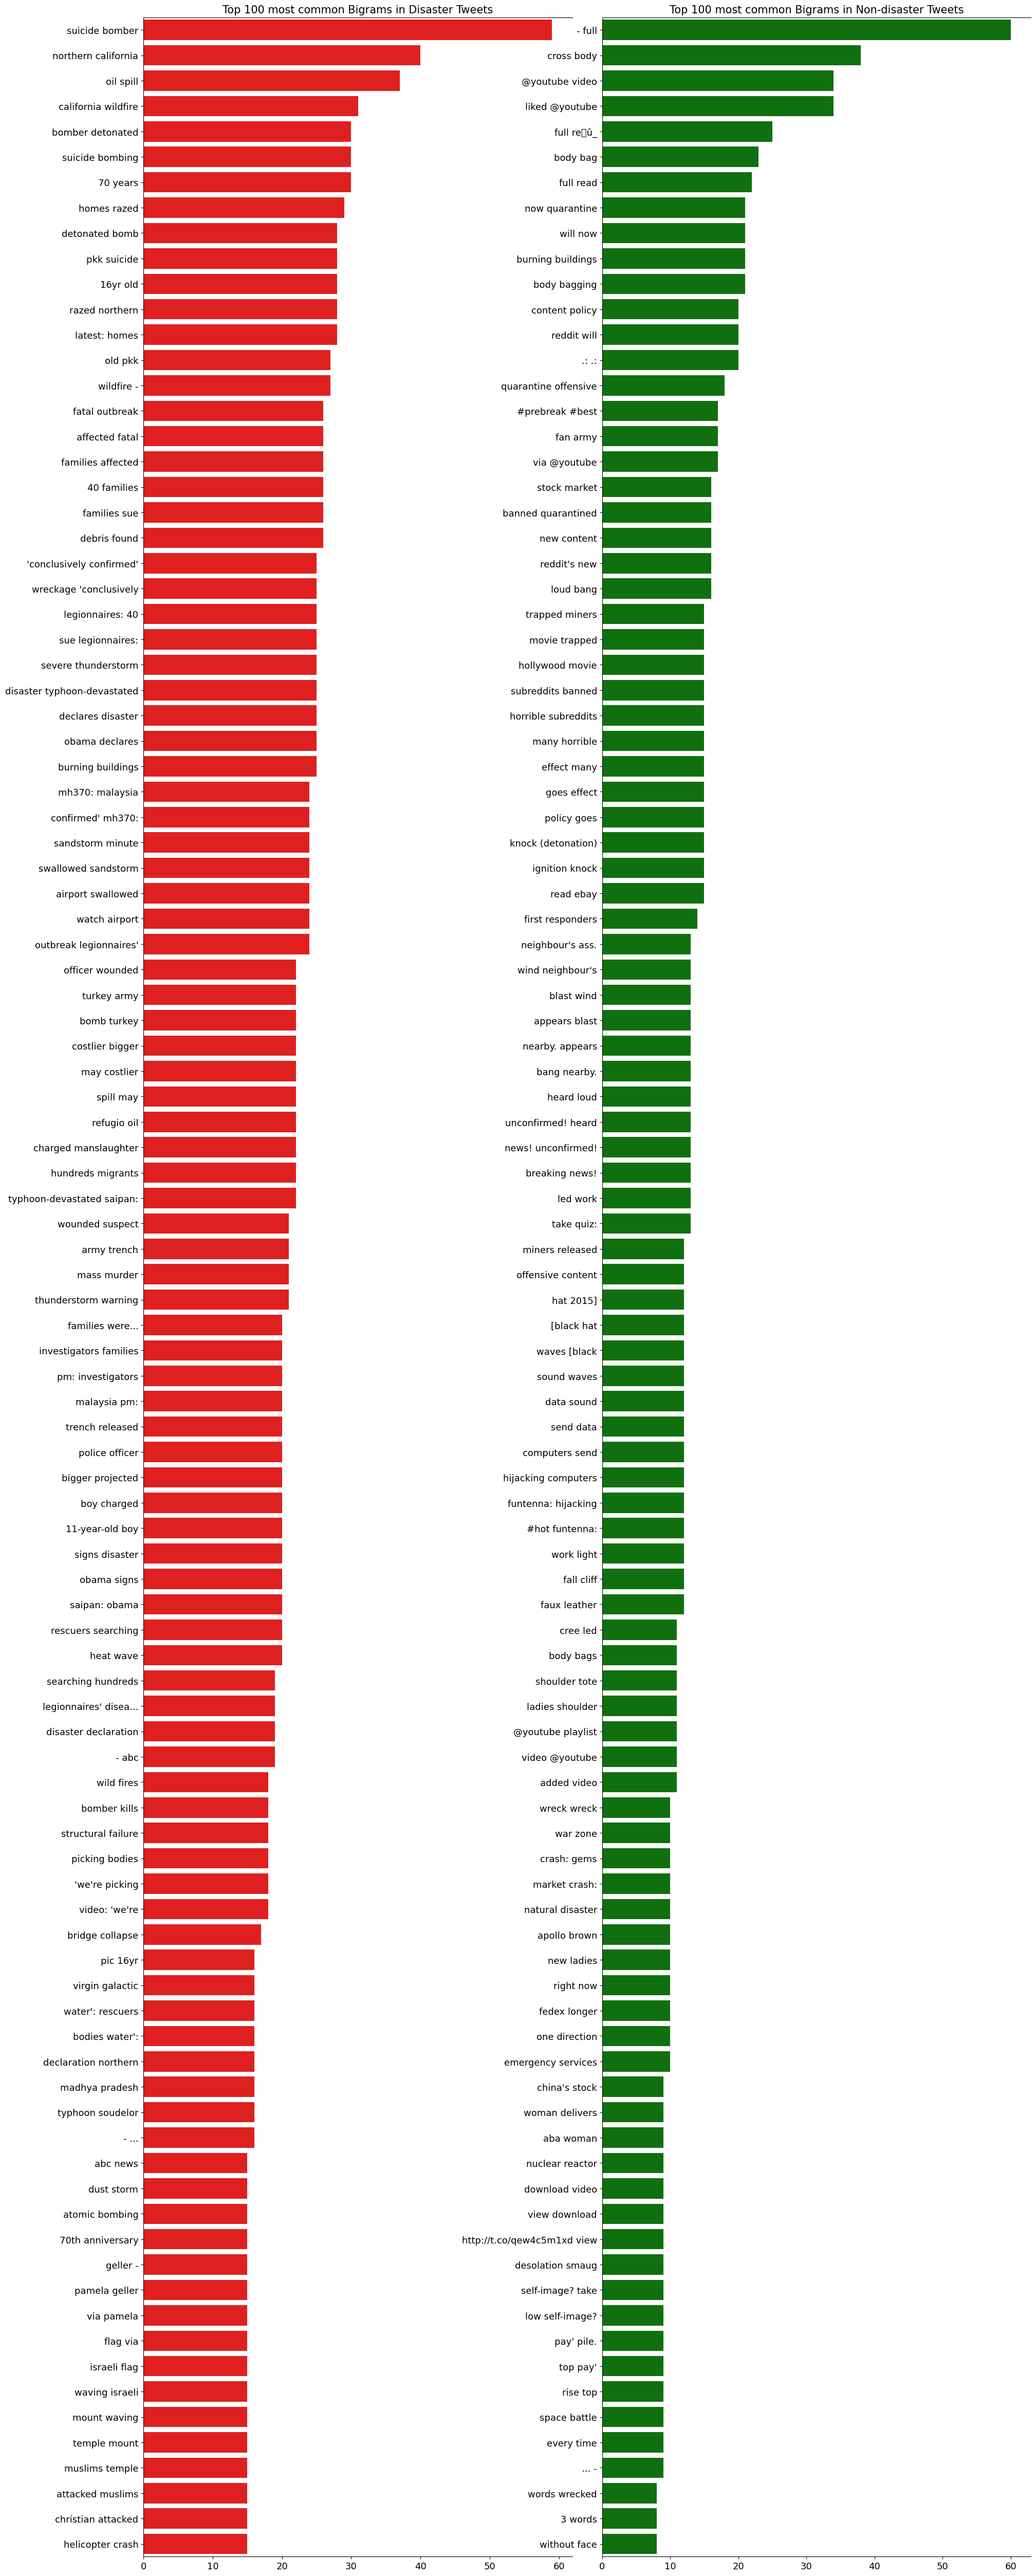

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18,50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color="red")
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color="green")
#axes로 disaster / non-disaster구분함
#값들이 딕셔너리 형태로 지정이 되어 있으니, unigram[0]은 키 / unigram[1]은 값. 후에 N(100) 상위 100개 보여줌

for i in range(2):
  axes[i].spines["right"].set_visible(False)  #spines는 그래프의 테두리 선
  axes[i].set_xlabel("")
  axes[i].set_ylabel("")
  axes[i].tick_params(axis="x", labelsize=13)
  axes[i].tick_params(axis="y", labelsize=13)

axes[0].set_title(f"Top {N} most common Bigrams in Disaster Tweets", fontsize=15)
axes[1].set_title(f"Top {N} most common Bigrams in Non-disaster Tweets", fontsize=15)

plt.show()

##Trigram 또한 bigram과 비슷함.
재난과 비재난의 공통 단어 없음.<br>
biggram과 비슷하며 크게 추가 정보 주지는 않음<br>
non-disaster도 전처리 과정 필요(구두점 많음)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


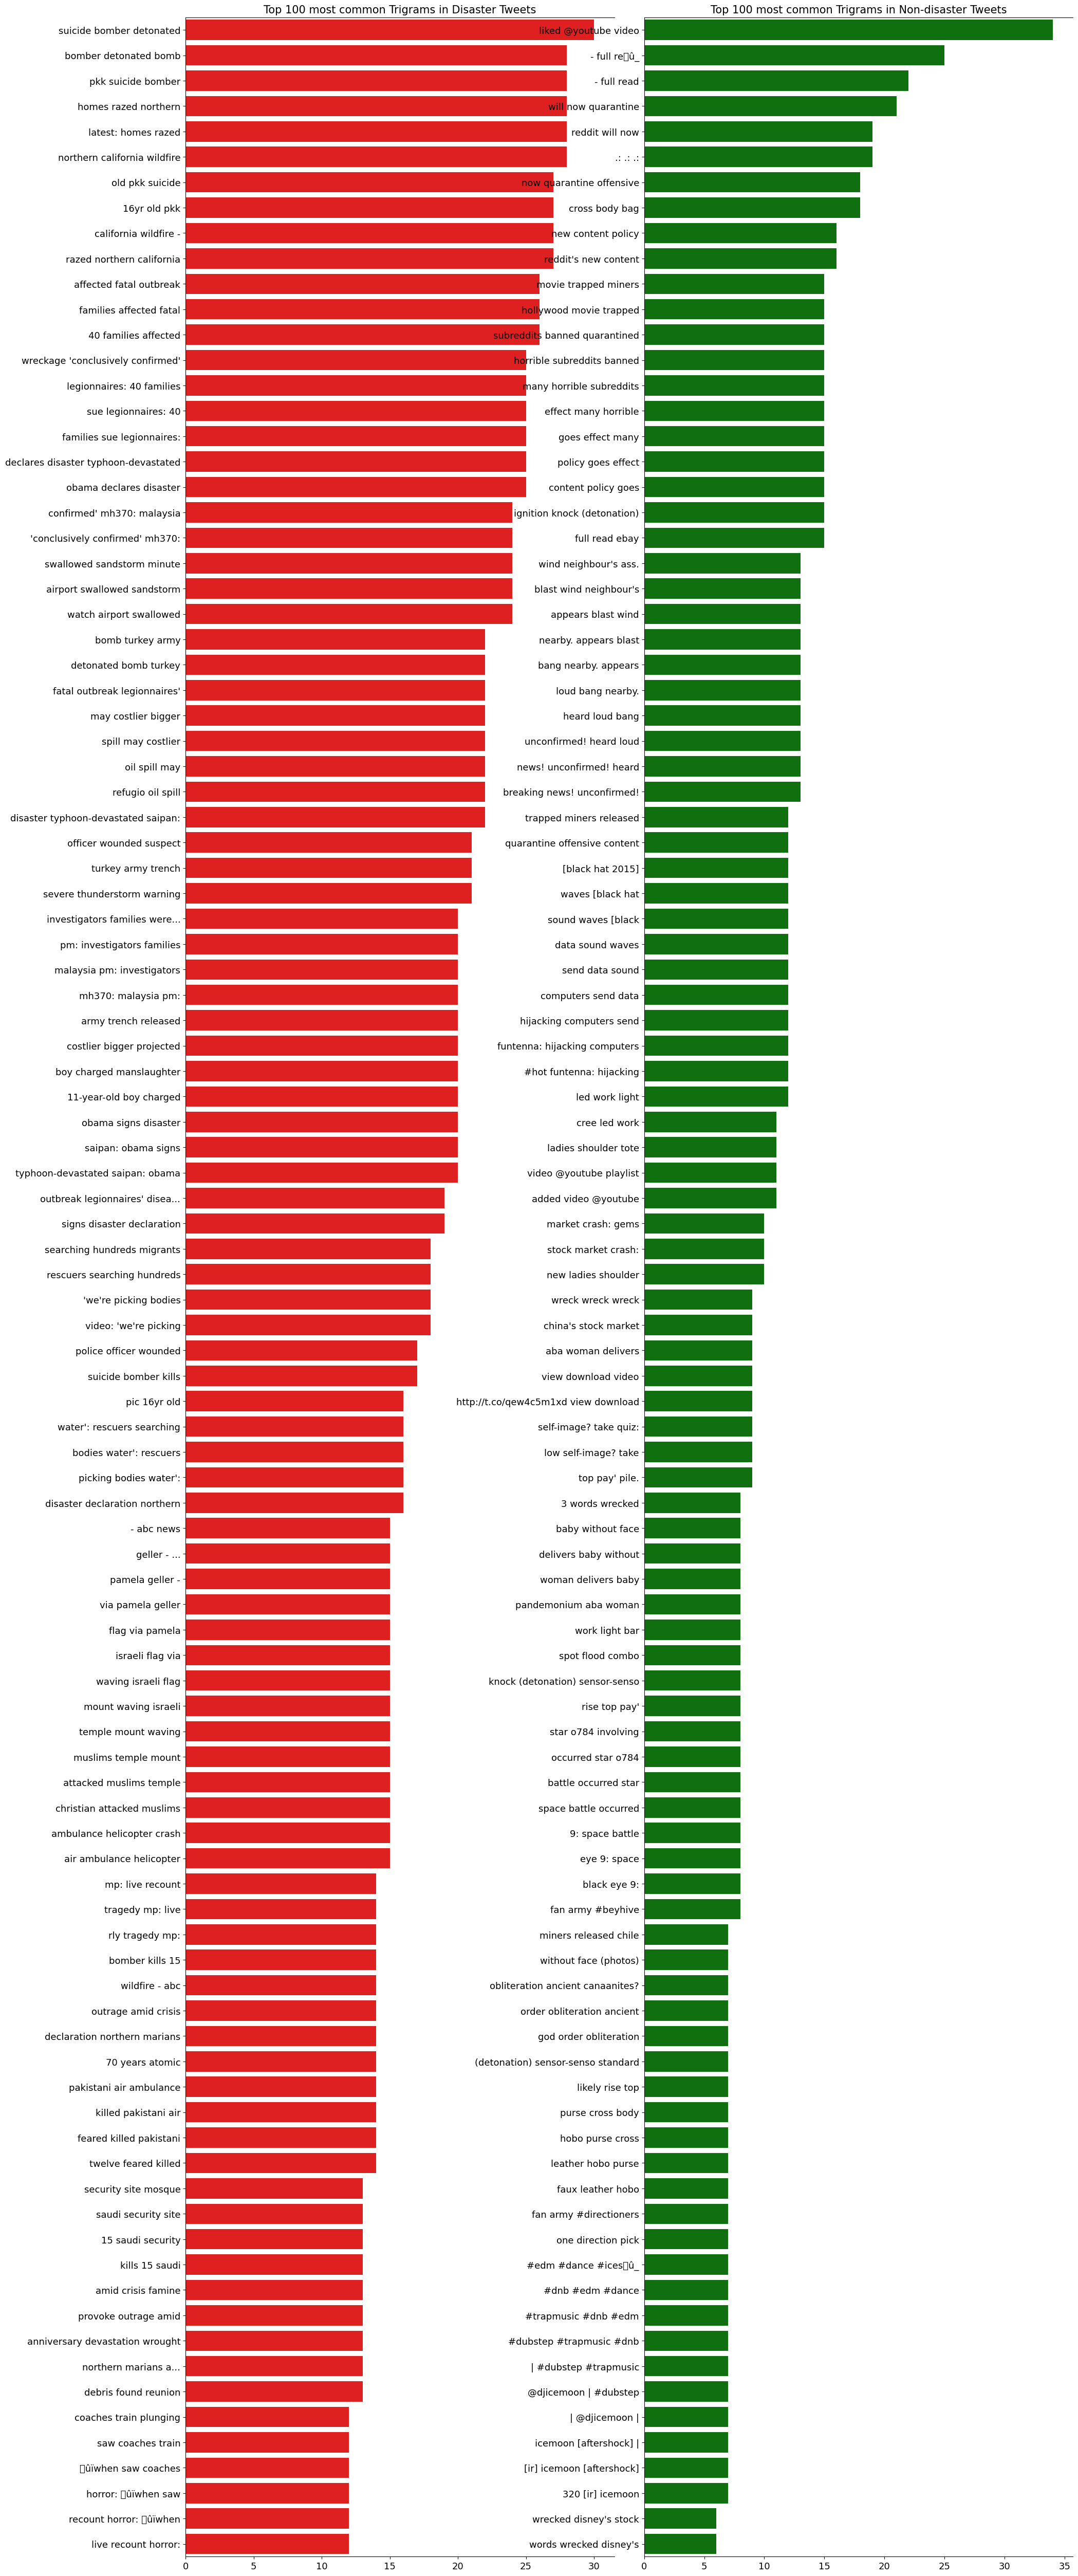

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18,50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color="red")
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color="green")
#axes로 disaster / non-disaster구분함
#값들이 딕셔너리 형태로 지정이 되어 있으니, unigram[0]은 키 / unigram[1]은 값. 후에 N(100) 상위 100개 보여줌

for i in range(2):
  axes[i].spines["right"].set_visible(False)  #spines는 그래프의 테두리 선
  axes[i].set_xlabel("")
  axes[i].set_ylabel("")
  axes[i].tick_params(axis="x", labelsize=13)
  axes[i].tick_params(axis="y", labelsize=13)

axes[0].set_title(f"Top {N} most common Trigrams in Disaster Tweets", fontsize=15)
axes[1].set_title(f"Top {N} most common Trigrams in Non-disaster Tweets", fontsize=15)

plt.show()

##4. Embeding and Text Cleaning
1. 텍스트 전처리를 할 때 사전 훈련된 것으로 하면 중요한 데이터 날라갈 수 있음.

2. 어휘를 임베딩에 가능한 한 가깝게 가져오는 것. 이를 위해 트윗의 단어 수를 세어 훈련 어휘와 테스트 어휘 만듬.(어휘가 사전 훈련된 임베딩의 어휘와 최대한 일치하도록 하는 것)
3. GloVe-300d-840B,
FastText-Crawl-300d-2M"
2가지 임베딩을 기준으로 진행

매번 다운로드 안 해도 될듯, 처음에는 다운로

In [ ]:
# from urllib.request import urlretrieve, urlopen
# import gzip
# import zipfile

# urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
# zf = zipfile.ZipFile('glove.6B.zip')
# zf.extractall()
# zf.close()

#glove

In [ ]:
def load_glove(file):
    embeddings = {}
    with open(file, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coeffs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coeffs
    return embeddings

glove_embeddings = load_glove("glove.6B.300d.txt")


#glove를 300차원으로 불러옴.
데이터의 차원 장단점
장점
1.복잡성 반영, 더 많은 정보 포함. 다양한 특징 포착<br>
2.계산량 증가, 차원이 증가하면 데이터 포인트 간의 거리도 증가해서 모델 학습 어려움. 많은 데이터 -> 알고리즘 성능 저하
과적합., 많은 저장공간, 메모리 필요

#fasttext는 오류가 발생해서 일단 빼고 진행

##모델 함수 쪽은 더 공부하기!!

In [ ]:
def build_vocab(X): #각 트윗은 띄어쓰기를 기준으로 분할. 단어의 발생 빈도는 vocab에 저장

    tweets = X.apply(lambda s: s.split()).values #X값을 받으면 공백을 기준으로 저장함
    vocab = {}

    for tweet in tweets: #전체에서 트윗으로 나눔 (ex: ["i love me"], ["l like you"])처럼 그럼 tweet은 ["i love me"]
        for word in tweet: #["i love me"]에서 각 단어별로 한 번 더 ["i", "love", "me"] 이렇게 함으로써 각 단어를 계산할 수 있음
            try:
                vocab[word] += 1
            except KeyError: #key error vocab에 존재하지 않으면 (새로운 키트로 추가하고 1을 입력)
                vocab[word] = 1
    return vocab #단어 개수 세는 것


def check_embeddings_coverage(X, embeddings): #어떤 단어들이 임베딩에 포함, 포함x 알려줌

    vocab = build_vocab(X)

    covered = {} #임베딩 포함
    oov = {}    #임베딩 포함 x
    n_covered = 0
    n_oov = 0
#위 함수를 걸쳐서 들어온 함수는 개수를 셈으로써 이미 임베딩이 되어있음.
#임베딩이 되어있는, 안 되어있는 것을 구분
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]

    vocab_coverage = len(covered) / len(vocab) #임베딩이 전체 어휘 중 얼마나 많은 단어를 포함하고 있는지
    text_coverage = (n_covered / (n_covered + n_oov))#임베딩이 전체 텍스트 중 얼마나 많은 부분을 포함하고 있는지 비율

    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1] #개수가 큰 부분으로 내림차순
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text'], glove_embeddings) #train값 임베딩 보여주기
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text'], glove_embeddings) #test값 임베딩 보여주기
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

# train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text'], fasttext_embeddings)
# test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text'], fasttext_embeddings)
# print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
# print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 23.64% of vocabulary and 56.70% of text in Training Set
GloVe Embeddings cover 27.22% of vocabulary and 55.76% of text in Test Set


##Text Cleaning
매 트위터 text마다 전처리 불가능<br>
punctuations들만 제거 (@, &, ',...)
-임베딩에서 누락된 대부분의 단어들은 단어의 시작이나 끝에 구두점이 있음 -> 정제 필요
(이러한 구두점 대문에 해당 단어들은 임베딩을 갖고 있지 않음)<br>
따라서 구두점들은 단어들로부터 분리.<br>
또한 특수 문자는 완전히 제거, 줄임말은 풀어서 표기, url은 제거. 또한 문자 엔터티 참조는 실제 기호로 대체, 오타와 속어는 수정, 비공식적인 약어는 원래의 긴형태로 표기

마지막으로, 해시태그와 사용자 이름에는 맥락에 대한 많은 정보가 포함되어 있지만 띄어쓰기 없이 연결되어 쓰이기 때문에 해당 단어들에 대한 임베딩이 존재하지 않음.

##clean 함수부분 오래걸리는것 같음 (7분 소요)

In [ ]:
%%time

def clean(tweet):  #전처리 과정

    # Special characters 특수문자들 공백처리
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)

    # Contractions 어퍼스트로피 제거 후 펼쳐주기
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)
    tweet = re.sub(r"donå«t", "do not", tweet)

    # Character entity references 개행문자 형
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)

    # Typos, slang and informal abbreviations 슬랭 펼쳐주기
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)

    # Hashtags and usernames 이름 띄어쓰기
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet)
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)

    # Urls / url 공백
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)

    # Words with punctuations and special characters / 특수문자 처리
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')

    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')

    # Acronyms #머리글자 (AIDS 같이 앞문자만 따온것)
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)

    # Grouping same words without embeddings #임베딩 안되어 있는 것
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)

    return tweet
#정제된 TEXT다시 넣기
df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean(s))
df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean(s))
#함수 이용해서 다시 값 확
train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

# train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], fasttext_embeddings)
# test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], fasttext_embeddings)
# print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
# print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 40.27% of vocabulary and 72.72% of text in Training Set
GloVe Embeddings cover 43.49% of vocabulary and 72.17% of text in Test Set
CPU times: user 5min 14s, sys: 592 ms, total: 5min 14s
Wall time: 5min 25s


5. 잘못된 라벨링.
일관성이 없이 라벨링된 샘플 있음. (ex 동일한 트윗이 다른 라벨로 여러번 태깅)
이런 잘못된 라벨링 수정해줘야함



In [ ]:
df_mislabeled = df_train.groupby(["text"]).nunique().sort_values(by="target", ascending=False) #유니크한 값들만 보여줌, target 개수가 많은 것으로 내림차순
#"i am sad"라는 값이 target으로 0과 1을 가지고 있으면 -> 그 값은 2가 되는 것임(target값을 기준으로)
#그래서 target값을2개 가지고 있는 값 1을 초과한 값을 보여주는 것
df_mislabled = df_mislabeled[df_mislabeled["target"] > 1]["target"] #target 컬럼의 유일한 값의 개수가 1보다 큰 트윗만 선택
df_mislabeled.index.tolist() #잘못된 레이블들 리스트로 반

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

#target_relabeled라는 값을 복사해서 붙여넣은다음 라벨링을 다시 해주기!

In [ ]:
df_train["target_relabeled"] = df_train["target"].copy()

df_train['target_relabeled'] = df_train['target'].copy()

df_train.loc[df_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

##cross validation
학습과 테스트 세트가 키워드 그룹 내에서 분할되었다는 것을 알 수 있음.
id 특성을 보면서도 이러한 결론을 낼 수 있음.
모든 키워드가 교차 검증을 위한 학습 및 테스트 세트를 생성할 때 계층화 되었다는 것을 의미 (골고루 분배되었으니!)

즉, 각 키워드 그룹의 트윗은 학습 및 테스트 세트 모두에 존재하며 동일한 표본에서 가져온 것. 동일한 분할 기법을 복제하기 위해 stratifiedKFold를 사용하고 키워드를 y로 전달. 키워드를 기반으로 계층화 수행.
추가적인 학습 다양성을 위해 shuffle = true로 진행.

원래는 fasttext 라이브러리를 이용해서 전처리를 해줘야하지만 오류로 인해서 일단 가벼운 전처리 진행 (이부분만 처리 잘 해도 정확도 3프로는 올라갈 것!)

In [ ]:
import re

def clean(text):
    # URL 제거
    text = re.sub(r'http\S+', '', text)

    # HTML 태그 제거
    text = re.sub(r'<.*?>', '', text)

    # 특수 문자 제거
    text = re.sub(r'[^\w\s]', '', text)

    # 숫자 제거
    text = re.sub(r'\d+', '', text)

    # 소문자로 변환
    text = text.lower()

    return text

df_train['text_cleaned'] = df_train['text'].apply(lambda s: clean(s))


In [ ]:
df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean(s))


In [ ]:
K = 2 #교차반복 2번 하기
skf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)

DISASTER = df_train['target'] == 1
print('Whole Training Set Shape = {}'.format(df_train.shape))
print('Whole Training Set Unique keyword Count = {}'.format(df_train['keyword'].nunique()))
print('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(df_train[DISASTER]['target_relabeled'].count(), df_train[~DISASTER]['target_relabeled'].count()))

for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train['text_cleaned'], df_train['target']), 1):
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, df_train.loc[trn_idx, 'text_cleaned'].shape, df_train.loc[val_idx, 'text_cleaned'].shape))
    print('Fold {} Training Set Unique keyword Count = {} - Validation Set Unique keyword Count = {}'.format(fold, df_train.loc[trn_idx, 'keyword'].nunique(), df_train.loc[val_idx, 'keyword'].nunique()))

Whole Training Set Shape = (7613, 16)
Whole Training Set Unique keyword Count = 222
Whole Training Set Target Rate (Disaster) 3271/4342 (Not Disaster)

Fold 1 Training Set Shape = (3806,) - Validation Set Shape = (3807,)
Fold 1 Training Set Unique keyword Count = 222 - Validation Set Unique keyword Count = 222

Fold 2 Training Set Shape = (3807,) - Validation Set Shape = (3806,)
Fold 2 Training Set Unique keyword Count = 222 - Validation Set Unique keyword Count = 222


##f1스코어는 precion과 recall 조화
keras에서는 accuracy는 제공하지만, 다른 지표들(precision, recall)제공 x 따라서 classificationreport를 사용하여서 해당 지표 계

##분류 class -> 이부분은 잘 모르겠음..

In [ ]:
class ClassificationReport(Callback):

    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()

        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []

        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)

        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)
        self.val_recall_scores.append(val_recall)
        self.val_f1_scores.append(val_f1)

        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))

#bert layer 사용

In [ ]:
%%time

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

CPU times: user 10.1 s, sys: 1.93 s, total: 12 s
Wall time: 16.8 s


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.3 MB/s eta 0:00:00


#bert- pre-trained하는 부분 불러오기

In [ ]:
#Bert __init__윗 부분은 원래 이거지만
'''
        self.max_seq_length = max_seq_length
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
'''
#위의 코드는 구버전 ->신버전으로 바꿈
#아래가 신버전

In [ ]:
from transformers import BertTokenizer #gpt가 __init__부분 초기화 해줌
class DisasterDetector:

    def __init__(self, bert_layer, max_seq_length=128, lr=0.0001, epochs=15, batch_size=32):

        # BERT and Tokenization params
        self.bert_layer = bert_layer
        self.max_seq_length = max_seq_length #bert구버전에서 신버전으로 수정
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #여기까지 수정
        #pre-trained부분 불러옴
        # Learning control params
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size

        self.models = []
        self.scores = {}


    def encode(self, texts):

        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            encoded = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_seq_length,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                truncation=True
            )

            all_tokens.append(encoded['input_ids'])
            all_masks.append(encoded['attention_mask'])
            all_segments.append(encoded['token_type_ids'])

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)




    def build_model(self):

        input_word_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids')

        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])
        clf_output = sequence_output[:, 0, :]
        out = Dense(1, activation='sigmoid')(clf_output)

        model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
        optimizer = SGD(learning_rate=self.lr, momentum=0.8)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        return model


    def train(self, X):

        for fold, (trn_idx, val_idx) in enumerate(skf.split(X['text_cleaned'], X['keyword'])):

            print('\nFold {}\n'.format(fold))

            X_trn_encoded = self.encode(X.loc[trn_idx, 'text_cleaned'].str.lower())
            y_trn = X.loc[trn_idx, 'target_relabeled']
            X_val_encoded = self.encode(X.loc[val_idx, 'text_cleaned'].str.lower())
            y_val = X.loc[val_idx, 'target_relabeled']

            # Callbacks
            metrics = ClassificationReport(train_data=(X_trn_encoded, y_trn), validation_data=(X_val_encoded, y_val))

            # Model
            model = self.build_model()
            model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=self.epochs, batch_size=self.batch_size)

            self.models.append(model)
            self.scores[fold] = {
                'train': {
                    'precision': metrics.train_precision_scores,
                    'recall': metrics.train_recall_scores,
                    'f1': metrics.train_f1_scores
                },
                'validation': {
                    'precision': metrics.val_precision_scores,
                    'recall': metrics.val_recall_scores,
                    'f1': metrics.val_f1_scores
                }
            }


    def plot_learning_curve(self):

        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)

        for i in range(K):

            # Classification Report curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['val_accuracy'], ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')

            axes[i][0].legend()
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

            # Loss curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['loss'], ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['val_loss'], ax=axes[i][1], label='val_loss')

            axes[i][1].legend()
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()


    def predict(self, X):

        X_test_encoded = self.encode(X['text_cleaned'].str.lower())
        y_pred = np.zeros((X_test_encoded[0].shape[0], 1))

        for model in self.models:
            y_pred += model.predict(X_test_encoded) / len(self.models)

        return y_pred

##BERT 모델 학습하는 과정
bert모델은 기본 pre-trained된 모델을 fine-tuning사용하는 모델
k=2로 줘서 fold 0 / fold 1 교차검증

In [ ]:
clf = DisasterDetector(bert_layer, max_seq_length=128, lr=0.0001, epochs=10, batch_size=32)
#Bert_layer : pre-trained된 모델 설정
#max_sqe_length: 입력 텍스트의 최대 길이
#lr: 학습률
#epoch:반복 횟수
#batch_size = 한 번에 학습할 데이터의 크기 (32 text)
clf.train(df_train) #df_train을 통해서 학습


Fold 0



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Epoch 1/10
119/119 [==============================] - ETA: 0s - loss: 0.6391 - accuracy: 0.6537
Epoch: 1 - Training Precision: 0.731176 - Training Recall: 0.713937 - Training F1: 0.71727
Epoch: 1 - Validation Precision: 0.721069 - Validation Recall: 0.701727 - Validation F1: 0.704635
119/119 [==============================] - 241s 2s/step - loss: 0.6391 - accuracy: 0.6537 - val_loss: 0.5870 - val_accuracy: 0.7208
Epoch 2/10
119/119 [==============================] - ETA: 0s - loss: 0.5292 - accuracy: 0.7541
Epoch: 2 - Training Precision: 0.769405 - Training Recall: 0.762147 - Training F1: 0.764686
Epoch: 2 - Validation Precision: 0.756197 - Validation Recall: 0.748717 - Validation F1: 0.751194
119/119 [==============================] - 199s 2s/step - loss: 0.5292 - accuracy: 0.7541 - val_loss: 0.5141 - val_accuracy: 0.7594
Epoch 3/10
119/119 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.7861
Epoch: 3 - Training Precision: 0.801581 - Training Recall: 0.790263 -

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Epoch 1/10
119/119 [==============================] - ETA: 0s - loss: 0.5433 - accuracy: 0.7315
Epoch: 1 - Training Precision: 0.811281 - Training Recall: 0.803633 - Training F1: 0.806438
Epoch: 1 - Validation Precision: 0.836577 - Validation Recall: 0.831829 - Validation F1: 0.833816
119/119 [==============================] - 224s 2s/step - loss: 0.5433 - accuracy: 0.7315 - val_loss: 0.4095 - val_accuracy: 0.8384
Epoch 2/10
119/119 [==============================] - ETA: 0s - loss: 0.4309 - accuracy: 0.8148
Epoch: 2 - Training Precision: 0.822194 - Training Recall: 0.818861 - Training F1: 0.820303
Epoch: 2 - Validation Precision: 0.83872 - Validation Recall: 0.837623 - Validation F1: 0.838147
119/119 [==============================] - 199s 2s/step - loss: 0.4309 - accuracy: 0.8148 - val_loss: 0.3902 - val_accuracy: 0.8418
Epoch 3/10
119/119 [==============================] - ETA: 0s - loss: 0.4043 - accuracy: 0.8314
Epoch: 3 - Training Precision: 0.841933 - Training Recall: 0.831213 -

##df_train 확인해보기 (값 생김새 다시 보기)

In [ ]:
df_train.head(10)

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,text_cleaned,target_relabeled
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,4.384615,69,1,1,0,our deeds are the reason of this earthquake ma...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,38,1,0,0,forest fire near la ronge sask canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,133,3,0,0,all residents asked to shelter in place are be...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0,people receive wildfires evacuation orders in...,1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,0,4.500000,88,2,2,0,just got sent this photo from ruby alaska as s...,1
5,8,no_keyword,no_location,#RockyFire Update => California Hwy. 20 closed...,1,18,18,3,0,5.166667,110,7,3,0,rockyfire update california hwy closed in bo...,1
6,10,no_keyword,no_location,#flood #disaster Heavy rain causes flash flood...,1,14,14,2,0,5.857143,95,3,2,0,flood disaster heavy rain causes flash floodin...,1
7,13,no_keyword,no_location,I'm on top of the hill and I can see a fire in...,1,15,14,10,0,3.000000,59,4,0,0,im on top of the hill and i can see a fire in ...,1
8,14,no_keyword,no_location,There's an emergency evacuation happening now ...,1,12,11,5,0,5.666667,79,1,0,0,theres an emergency evacuation happening now i...,1
9,15,no_keyword,no_location,I'm afraid that the tornado is coming to our a...,1,10,10,6,0,4.300000,52,4,0,0,im afraid that the tornado is coming to our area,1


1. Classification Report 그래프:

이 그래프는 val_accuracy, val_precision, val_recall, val_f1 네 가지 성능 지표를 시각화합니다.
val_accuracy: 검증 데이터에서의 정확도를 나타냅니다.
val_precision: 검증 데이터에서의 정밀도를 나타냅니다. 정밀도는 양성으로 예측된 항목 중 실제 양성 클래스의 비율을 의미합니다.
val_recall: 검증 데이터에서의 재현율을 나타냅니다. 재현율은 실제 양성 클래스 중 양성으로 예측된 항목의 비율을 의미합니다.
val_f1: 검증 데이터에서의 F1 점수를 나타냅니다. F1 점수는 정밀도와 재현율의 조화 평균을 의미합니다.
2. Loss 그래프:

이 그래프는 학습 데이터(train_loss)와 검증 데이터(val_loss)에 대한 손실(loss) 값을 시각화합니다.
손실 값은 모델이 학습하는 동안 최적화하려고 하는 값입니다. 일반적으로 손실 값이 낮아지면 모델의 성능이 좋아진다고 볼 수 있습니다.
train_loss: 학습 데이터에 대한 손실 값을 나타냅니다.
val_loss: 검증 데이터에 대한 손실 값을 나타냅니다.

loss 데이터를 보면 4부분에서 val_loss가 줄어들지 않는 것을 볼 수 있음 ->과적합 되었다는 말

과적합을 해소하기 위해서는

1. 조기 종료 (Early Stopping):

val_loss가 일정 epoch 동안 개선되지 않을 경우 학습을 중단합니다. 예를 들어, 4 epochs 동안 val_loss가 줄어들지 않으면 학습을 멈추는 방식입니다. 이를 통해 과적합을 방지할 수 있습니다.

2. 드롭아웃 (Dropout):
모델의 특정 뉴런을 확률적으로 비활성화하여 학습하는 동안 네트워크의 복잡도를 줄입니다.

3. 정규화 (Regularization):
가중치가 너무 큰 값을 가지지 않도록 모델에 패널티를 부과합니다. L1, L2 정규화와 같은 방법이 있습니다.

4.데이터 증강 (Data Augmentation):
학습 데이터를 인위적으로 증가시켜 데이터 다양성을 높입니다. 이는 이미지 데이터에서 특히 유용합니다.

5.학습률 감소 (Learning Rate Decay):
학습이 진행됨에 따라 학습률을 점차 감소시킵니다.

6.보다 복잡한 모델 사용:
모델의 용량이 너무 작아서 데이터의 패턴을 제대로 학습하지 못하는 경우에는 더 복잡한 모델을 사용하면 도움이 될 수 있습니다.

7.다른 모델 아키텍처 시도:
현재 모델 아키텍처가 최적이 아닐 수 있습니다. 다른 모델 구조나 다른 종류의 모델을 시도해 보세요.

8.학습 데이터 추가:
더 많은 학습 데이터를 수집하거나 활용합니다.

fold[0]번 / fold[1]번으로 2번 보여줌

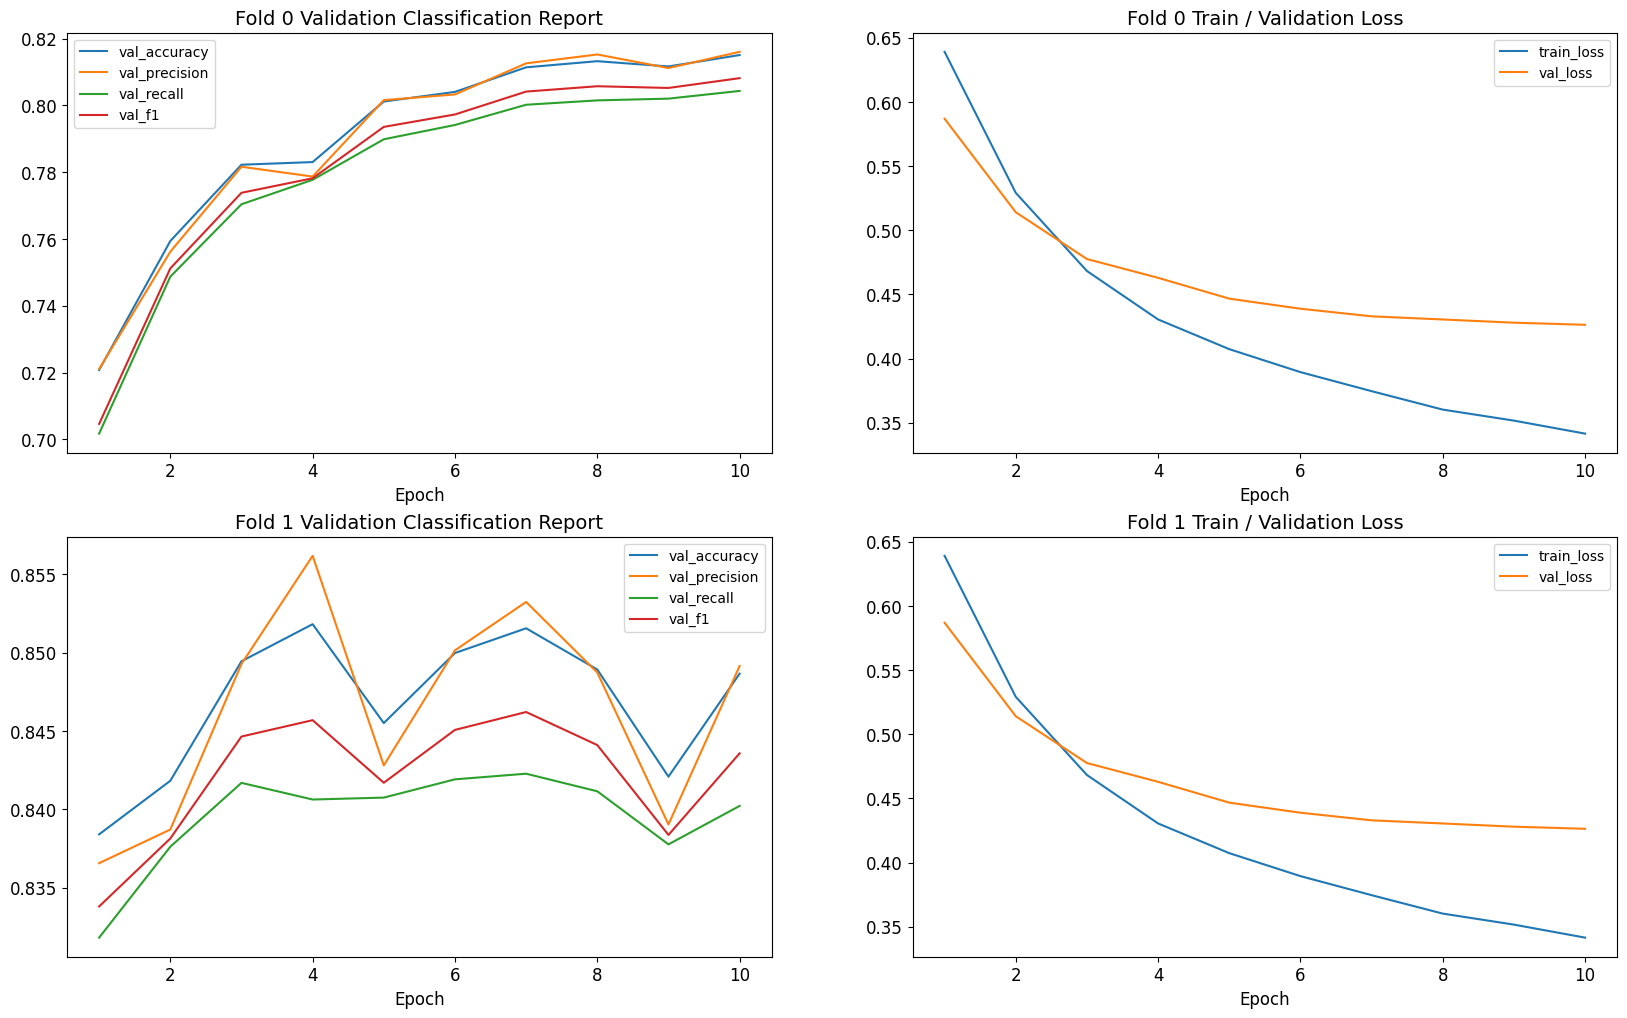

In [ ]:
clf.plot_learning_curve() #학습 중에 기록된 정확도, 손실 시각적으로 보여주는 그래프

In [ ]:
y_pred = clf.predict(df_test) #테스트 데이터로 예측하기

model_submission = pd.read_csv("/content/drive/MyDrive/4자연어처리_bert/sample_submission.csv") #sample data 불러옴 (제공 받은) Target값이 모두 0
model_submission['target'] = np.round(y_pred).astype('int') #예측결과를 반올림항 정수로 변환 한 후 target열에 저장
model_submission.to_csv('model_submission.csv', index=False) #정수로 바꾼 모델 결과 값
model_submission.describe() #데이터 프레임의 기초 통계량(평균, 표준편차, 최솟값, 최대값 등 출력)

102/102 [==============================] - 27s 270ms/step


,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.418020
std,3146.427221,0.493309
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


정확도 81% 나옴
전처리 과정에서 되지 않은 코드가 있어서 아쉬웠음.

epoch가 4일때 정확도 loss등이 제일 좋다고 생각했음, 그 뒤로는 과적합이라고 생각했음. 그래서 epoch를 4로 했는데, 정확도가 더 낮아짐..

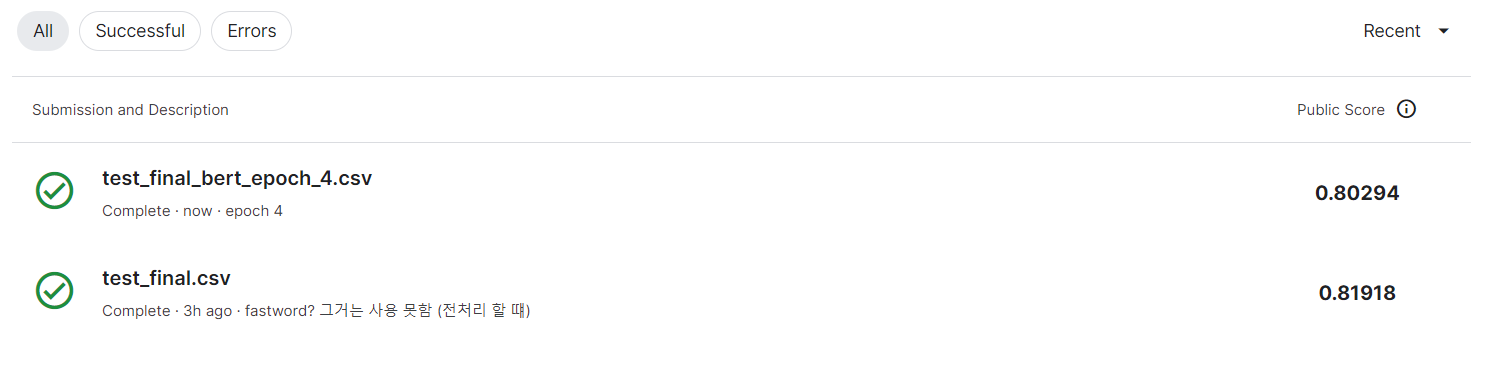